In [248]:
import numpy as np
import pandas as pd
from numba import njit
from scipy.stats import norm, halfnorm, uniform
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Get rid of annoying tf warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import bayesflow as beef
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from keras.utils import to_categorical
from sklearn.metrics import r2_score

import sys
sys.path.append("../src/")
from priors import sample_eta, sample_random_walk
from model import sample_softmax_rl
from context import generate_context
from configurator import configure_input
from helpers import softmax

In [249]:
%load_ext autoreload
%autoreload 2
# Suppress scientific notation for floats
np.set_printoptions(suppress=True)
# Configure rng
RNG = np.random.default_rng()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [250]:
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
# print(tf.config.list_physical_devices('GPU'))

## Constants

In [251]:
TRAIN_NETWORK = False

In [252]:
# parameters
THETA_NAMES = ("Learning rate", "Learning rate", "Sensitivity")
THETA_LABELS= (r"$\alpha_{\text{selected}}$", r"$\alpha_{\text{unselected}}$", r"$\tau$")
ETA_NAMES = ("Transition scale", "Transition scale", "Transition scale")
ETA_LABELS= (r"$\sigma_{\alpha}$", r"$\sigma_{\alpha}$", r"$\sigma_{\tau}$")

# plotting
FONT_SIZE_1 = 22
FONT_SIZE_2 = 18
FONT_SIZE_3 = 16

import matplotlib
matplotlib.rcParams['font.serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "serif"

# analysis
NUM_VALIDATION_SIM = 400
NUM_SAMPLES = 500
NUM_RESIM = 100
NUM_OBS = 200

## Data Preparation

In [253]:
data = pd.read_csv("../data/empiric_data.csv")
NUM_SUBJECTS = len(np.unique(data.participant))

In [254]:
emp_data = np.full((42, 4), np.nan)

## Exemplar Trajectory

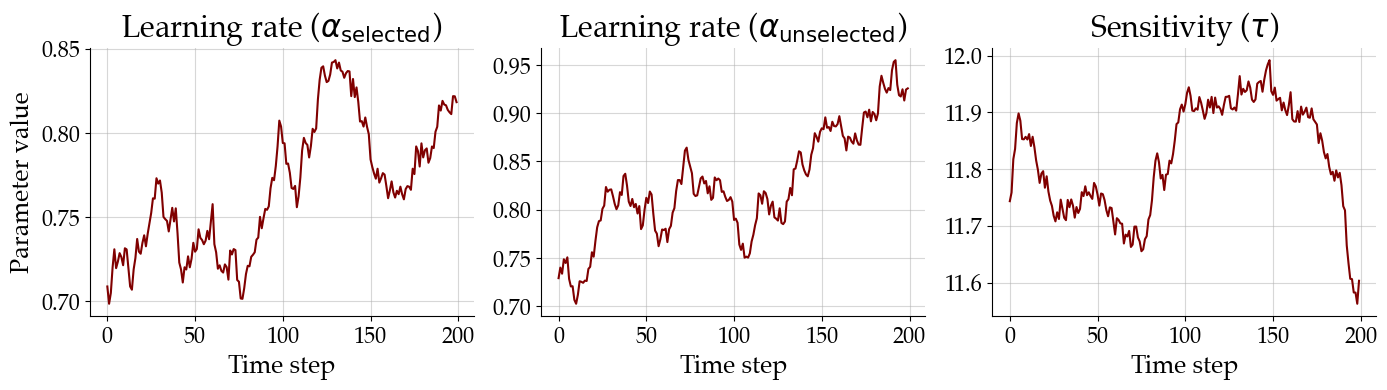

In [255]:
eta = sample_eta()
theta = sample_random_walk(eta)
time = np.arange(theta.shape[0])
fig, axarr = plt.subplots(1, 3, figsize=(14, 4))
for i, ax in enumerate(axarr.flat):
    ax.grid(alpha=0.5)
    ax.plot(
        time,
        theta[:, i],
        color='maroon'
    )
    ax.set_title(f'{THETA_NAMES[i]} ({THETA_LABELS[i]})', fontsize=FONT_SIZE_1)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    if i == 0:
        ax.set_ylabel("Parameter value", fontsize=FONT_SIZE_2)
    ax.set_xlabel("Time step", fontsize=FONT_SIZE_2)

sns.despine()
fig.tight_layout()

## Generative Model

### Prior

In [256]:
prior = beef.simulation.TwoLevelPrior(
    hyper_prior_fun=sample_eta,
    local_prior_fun=sample_random_walk,
)

In [257]:
GLOBAL_PRIOR_MEAN = np.array([0.02, 0.02, 0.8])
GLOBAL_PRIOR_STD = np.array([0.01, 0.01, 0.6])
LOCAL_PRIOR_MEAN = np.array([0.4, 0.4, 5.7])
LOCAL_PRIOR_STD = np.array([0.25, 0.25, 7.6])

### Context

In [258]:
context = beef.simulation.ContextGenerator(
    batchable_context_fun=generate_context,
)

### Likelihood

In [259]:
likelihood = beef.simulation.Simulator(
    simulator_fun=sample_softmax_rl,
    context_generator=context,
)

### Simulator

In [260]:
model = beef.simulation.TwoLevelGenerativeModel(
    prior=prior,
    simulator=likelihood,
    name="non-stationary_softmax_rl",
)

INFO:root:Performing 2 pilot runs with the non-stationary_softmax_rl model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 200, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 200)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 200, 3)
INFO:root:No shared_prior_draws provided.
INFO:root:Could not determine shape of simulation batchable context. Type appears to be non-array: <class 'list'>,                                    so make sure your input configurator takes care of that!
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.


## Neural Approximator

In [261]:
approximator_settings = {
    "lstm1_hidden_units": 512,
    "lstm2_hidden_units": 256,
    "lstm3_hidden_units": 128,
    "trainer": {
        "max_to_keep": 1,
        "default_lr": 5e-4,
        "memory": False,
    }
}

In [262]:
summary_network = beef.networks.HierarchicalNetwork(
    [
        Sequential(
            [
                Bidirectional(LSTM(approximator_settings["lstm1_hidden_units"], return_sequences=True)),
                Bidirectional(LSTM(approximator_settings["lstm2_hidden_units"], return_sequences=True)),
            ]
        ),
        Sequential(
            [
                Bidirectional(LSTM(approximator_settings["lstm3_hidden_units"]))
            ]
        )
    ]
)

In [263]:
local_network = beef.amortizers.AmortizedPosterior(
    beef.networks.InvertibleNetwork(
        num_params=3,
        num_coupling_layers=8,
        coupling_settings={
            "dense_args": dict(kernel_regularizer=None),
            "dropout": False,
            "coupling_design": 'interleaved'
        }
    )
)
global_network = beef.amortizers.AmortizedPosterior(
    beef.networks.InvertibleNetwork(
        num_params=3,
        num_coupling_layers=6,
        coupling_settings={
            "dense_args": dict(kernel_regularizer=None),
            "dropout": False,
            "coupling_design": 'interleaved'
        }
    )
)

In [264]:
amortizer = beef.amortizers.TwoLevelAmortizedPosterior(
    local_amortizer=local_network,
    global_amortizer=global_network,
    summary_net=summary_network
)
trainer = beef.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=configure_input,
    **approximator_settings.get("trainer"),
    checkpoint_path="../checkpoints/three_alt_full_feed"
)

INFO:root:Loaded loss history from ../checkpoints/three_alt_full_feed/history_200.pkl.
INFO:root:Networks loaded from ../checkpoints/three_alt_full_feed/ckpt-200
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


## Trainer

In [265]:
if TRAIN_NETWORK:
    history = trainer.train_online(
        epochs=200,
        iterations_per_epoch=1000,
        batch_size=32
    )
else:
    history = trainer.loss_history.get_plottable()

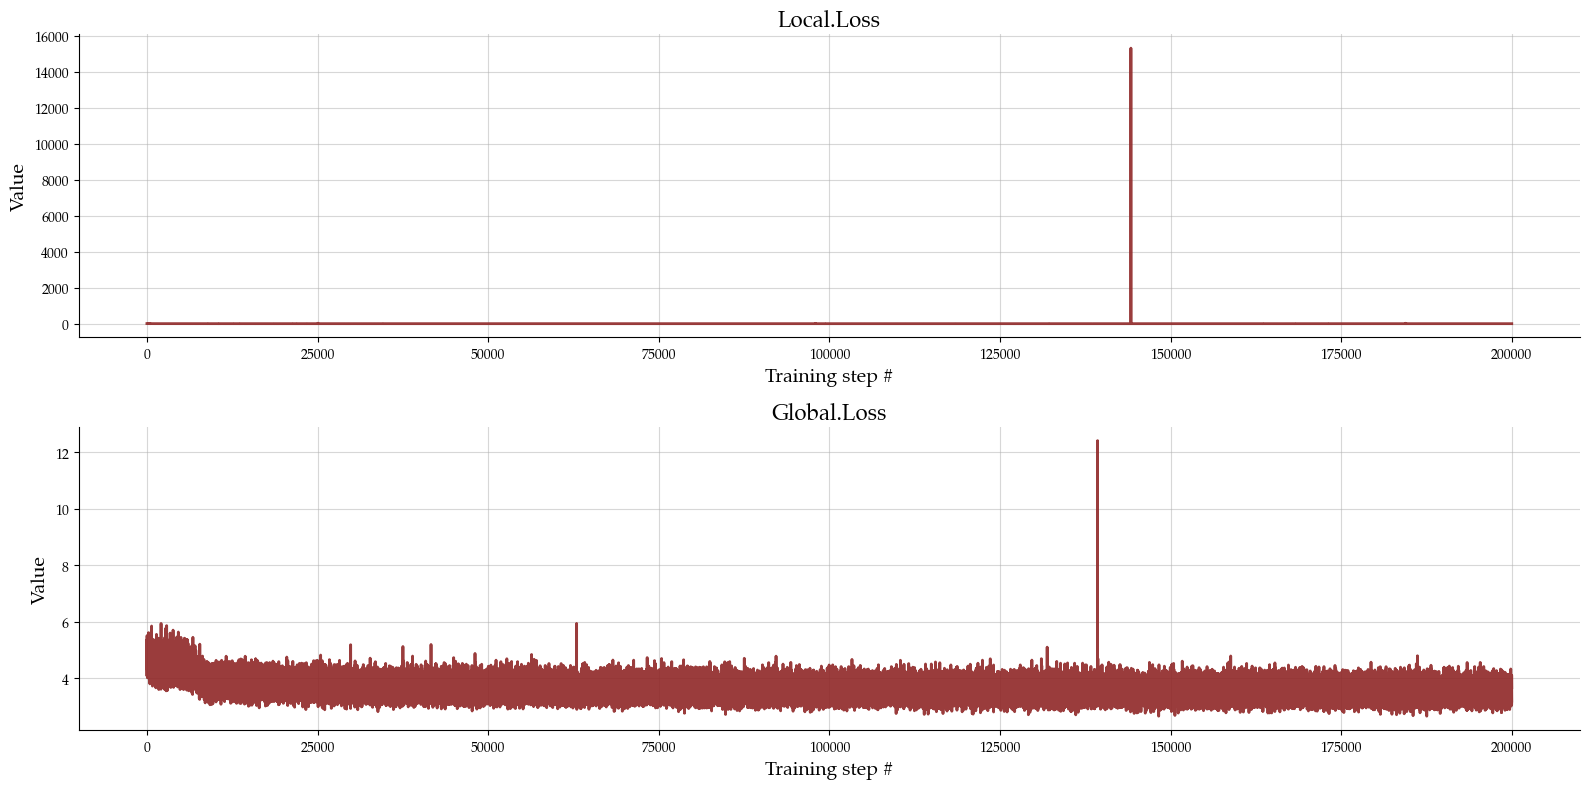

In [266]:
loss_plot = beef.diagnostics.plot_losses(history)

## Validation

In [293]:
val_data = model(1)
theta_true = val_data['local_prior_draws'][0]
eta_true = val_data['hyper_prior_draws'][0]

In [294]:
val_data_config = configure_input(val_data)

In [295]:
post_sample = amortizer.sample(val_data_config, n_samples=1000)

In [296]:
theta_post = post_sample['local_samples'] * LOCAL_PRIOR_STD + LOCAL_PRIOR_MEAN
theta_post_mean = theta_post.mean(axis=1)
theta_post_std = theta_post.std(axis=1)

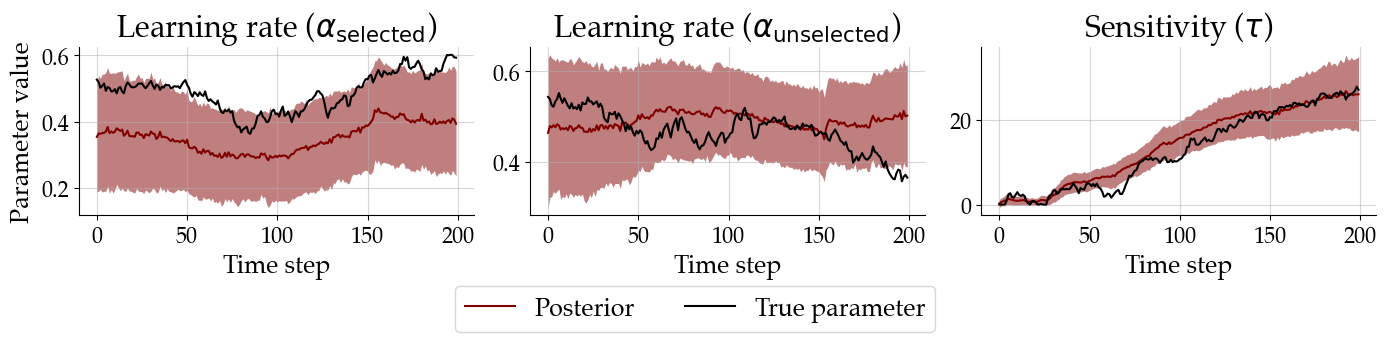

In [297]:
time = np.arange(theta_post_mean.shape[0])
fig, axarr = plt.subplots(1, 3, figsize=(14, 3))
for i, ax in enumerate(axarr.flat):
    ax.grid(alpha=0.5)
    ax.plot(
        time,
        theta_post_mean[:, i],
        color='maroon', label="Posterior"
    )
    ax.plot(
        time,
        theta_true[:, i],
        color='black', label="True parameter"
    )
    ax.fill_between(
        time,
        theta_post_mean[:, i] - theta_post_std[:, i],
        theta_post_mean[:, i] + theta_post_std[:, i],
        color='maroon', alpha=0.5, linewidth=0.0
    )
    ax.set_title(f'{THETA_NAMES[i]} ({THETA_LABELS[i]})', fontsize=FONT_SIZE_1)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    if i == 0:
        ax.set_ylabel("Parameter value", fontsize=FONT_SIZE_2)
        fig.subplots_adjust(hspace=0.5)
        fig.legend(fontsize=FONT_SIZE_2, bbox_to_anchor=(0.5, -0.05), loc="center", ncol=2)
    ax.set_xlabel("Time step", fontsize=FONT_SIZE_2)

sns.despine()
fig.tight_layout()

### Parameter Recovery

In [273]:
sim_data = model(NUM_VALIDATION_SIM)
theta_true = sim_data['local_prior_draws']
eta_true = sim_data['hyper_prior_draws']
sim_data_config = trainer.configurator(sim_data)['summary_conditions']
sim_data_config.shape

(400, 200, 6)

In [274]:
theta_post_z = np.zeros((NUM_VALIDATION_SIM, NUM_OBS, NUM_SAMPLES, 3))
eta_post_z = np.zeros((NUM_VALIDATION_SIM, NUM_SAMPLES, 3))

In [275]:
for i in tqdm(range(NUM_VALIDATION_SIM)):
    post_samples = amortizer.sample({'summary_conditions': sim_data_config[i][None, :, :]}, n_samples=NUM_SAMPLES)
    theta_post_z[i] = post_samples['local_samples']
    eta_post_z[i] = post_samples['global_samples']

100%|██████████| 400/400 [19:37<00:00,  2.94s/it]


#### Local Parameters

In [276]:
theta_post = theta_post_z * LOCAL_PRIOR_STD + LOCAL_PRIOR_MEAN
post_theta_means = theta_post.mean(axis=2)
post_theta_stds = theta_post.std(axis=2)
post_theta_median = np.median(theta_post, axis=2)

In [283]:
np.corrcoef(theta_true[:, 0, 0], post_theta_median[:, 0, 0])[0, 1]

0.7259889140299189

In [284]:
r2_scores = np.zeros((NUM_OBS, 3))
rmse = np.zeros((NUM_OBS, 3))
correlation = np.zeros((NUM_OBS, 3))
for t in range(NUM_OBS):
    for p in range(3):
        r2_scores[t, p] = r2_score(theta_true[:, t, p], post_theta_median[:, t, p])
        rmse[t, p] = np.sqrt(np.mean((theta_true[:, t, p] - post_theta_median[:, t, p])**2))
        correlation[t, p] = np.corrcoef(theta_true[:, t, p], post_theta_median[:, t, p])[0, 1]

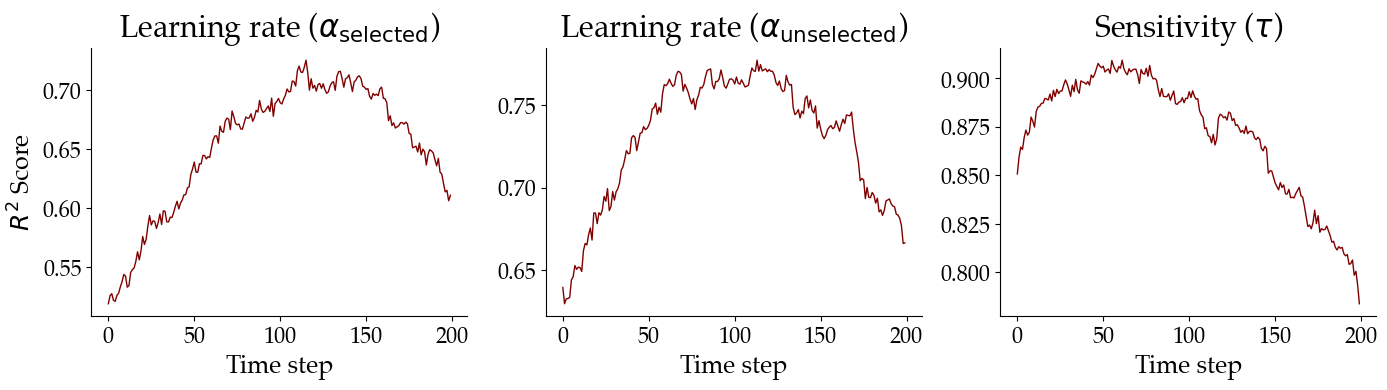

In [285]:
fig, axarr = plt.subplots(1, 3, figsize=(14, 4))
for i, ax in enumerate(axarr.flat):
    ax.plot(range(NUM_OBS), r2_scores[: , i], linewidth=1, color='maroon')
    ax.set_title(f'{THETA_NAMES[i]} ({THETA_LABELS[i]})', fontsize=FONT_SIZE_1)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    if i == 0:
        ax.set_ylabel(r"$R^2$ Score", fontsize=FONT_SIZE_2)
        fig.subplots_adjust(hspace=0.5)
    ax.set_xlabel("Time step", fontsize=FONT_SIZE_2)
sns.despine()
fig.tight_layout()

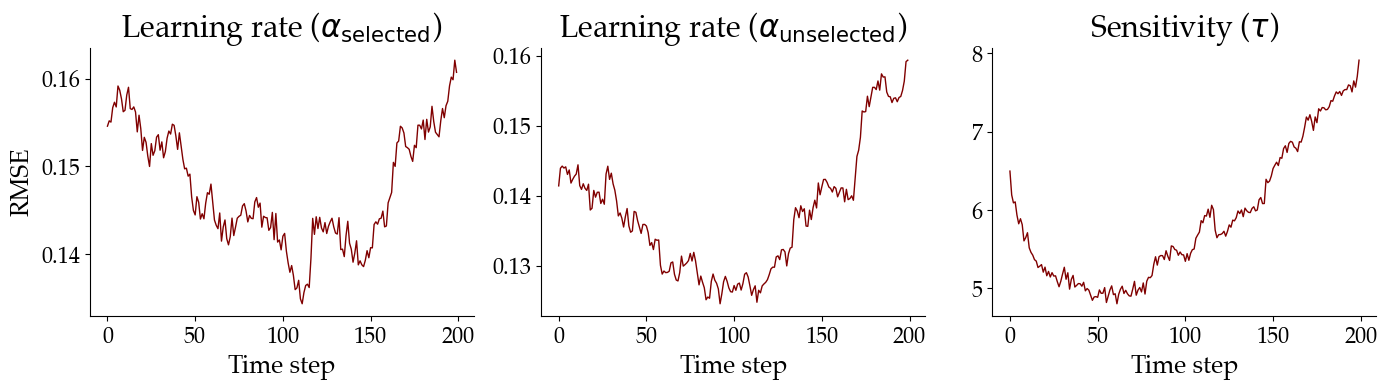

In [286]:
fig, axarr = plt.subplots(1, 3, figsize=(14, 4))
for i, ax in enumerate(axarr.flat):
    ax.plot(range(NUM_OBS), rmse[: , i], linewidth=1, color='maroon')
    ax.set_title(f'{THETA_NAMES[i]} ({THETA_LABELS[i]})', fontsize=FONT_SIZE_1)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    if i == 0:
        ax.set_ylabel("RMSE", fontsize=FONT_SIZE_2)
        fig.subplots_adjust(hspace=0.5)
    ax.set_xlabel("Time step", fontsize=FONT_SIZE_2)
sns.despine()
fig.tight_layout()

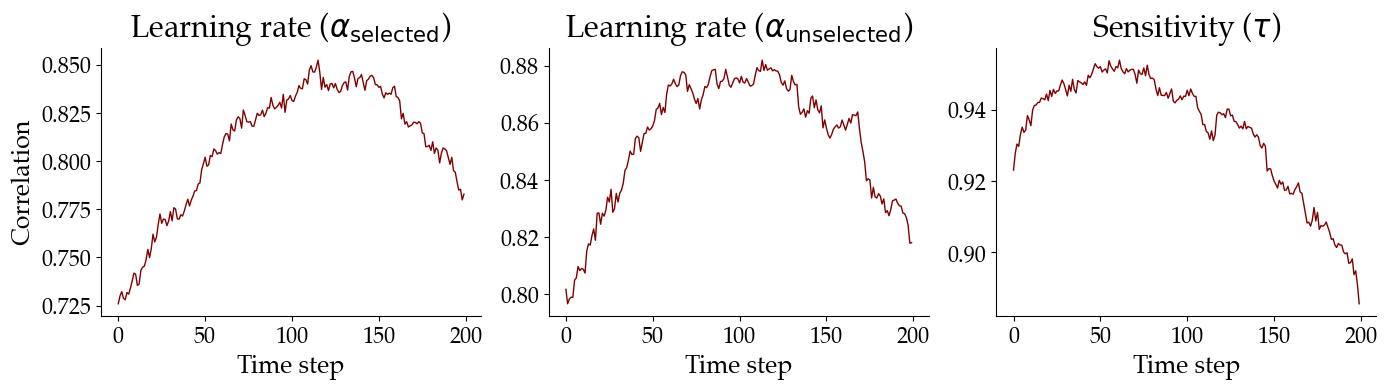

In [287]:
fig, axarr = plt.subplots(1, 3, figsize=(14, 4))
for i, ax in enumerate(axarr.flat):
    ax.plot(range(NUM_OBS), correlation[: , i], linewidth=1, color='maroon')
    ax.set_title(f'{THETA_NAMES[i]} ({THETA_LABELS[i]})', fontsize=FONT_SIZE_1)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    if i == 0:
        ax.set_ylabel("Correlation", fontsize=FONT_SIZE_2)
        fig.subplots_adjust(hspace=0.5)
    ax.set_xlabel("Time step", fontsize=FONT_SIZE_2)
sns.despine()
fig.tight_layout()

#### Global Parameters

In [164]:
eta_post = eta_post_z * GLOBAL_PRIOR_STD + GLOBAL_PRIOR_MEAN

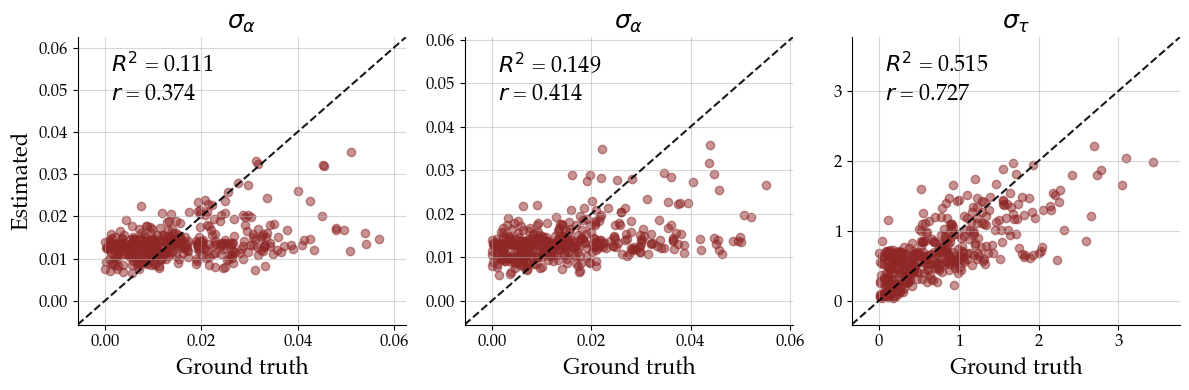

In [165]:
f = beef.diagnostics.plot_recovery(
    eta_post, eta_true,
    param_names=ETA_LABELS,
    uncertainty_agg=None
)

## Data Fitting

In [220]:
theta_post = np.full((NUM_SUBJECTS, 200, NUM_SAMPLES, 3), np.nan)
for i, sub in enumerate(tqdm(data.participant.unique())):
    person_data = data.loc[data.participant == sub]
    resp = person_data.choice.to_numpy() - 1
    context = np.c_[
        person_data.low_opt_feed.to_numpy(),
        person_data.mid_opt_feed.to_numpy(),
        person_data.high_opt_feed.to_numpy()
    ] / 30
    tmp_data = np.c_[
        to_categorical(resp)[None, :, :],
        context[None, :, :]
    ]
    post_samples = amortizer.sample({'summary_conditions': tmp_data}, n_samples=NUM_SAMPLES)
    num_obs = post_samples['local_samples'].shape[0]
    theta_post[i, :num_obs] = post_samples['local_samples'] * LOCAL_PRIOR_STD + LOCAL_PRIOR_MEAN

100%|██████████| 42/42 [02:10<00:00,  3.10s/it]


In [221]:
post_means = np.mean(theta_post, axis=2)
post_std = np.std(theta_post, axis=2)
post_means_mean = np.mean(post_means, axis=0)
post_means_std = np.std(post_means, axis=0)

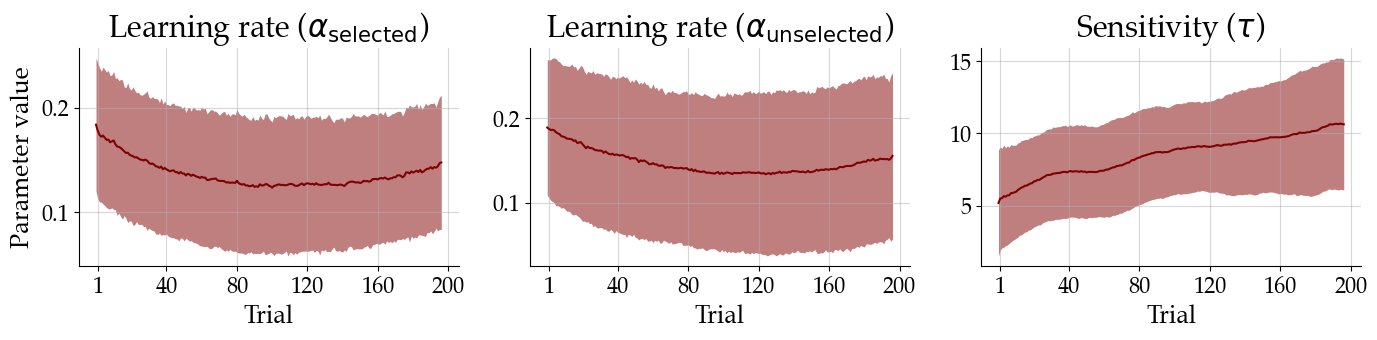

In [227]:
time = np.arange(post_means_mean.shape[0])
fig, axarr = plt.subplots(1, 3, figsize=(14, 3.5))
for i, ax in enumerate(axarr.flat):
    ax.grid(alpha=0.5)
    ax.plot(
        time,
        post_means_mean[:, i],
        color='maroon', label="Posterior"
    )
    ax.fill_between( 
        time,
        post_means_mean[:, i] - post_means_std[:, i],
        post_means_mean[:, i] + post_means_std[:, i],
        color='maroon', alpha=0.5, linewidth=0.0
    )
    ax.set_title(f'{THETA_NAMES[i]} ({THETA_LABELS[i]})', fontsize=FONT_SIZE_1)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    xticks = np.arange(0, 200+1, 40)
    xticks[0] = 1
    ax.set_xticks(xticks)
    if i == 0:
        # ax.set_yticks(np.arange(0, 1+0.1, 0.2))
        ax.set_ylabel("Parameter value", fontsize=FONT_SIZE_2)
        # fig.subplots_adjust(hspace=0.5)
        # fig.legend(fontsize=FONT_SIZE_2, bbox_to_anchor=(0.5, -0.05), loc="center", ncol=2)
    # if i == 1:
        # ax.set_yticks(np.arange(0, 1+0.1, 0.2))
    ax.set_xlabel("Trial", fontsize=FONT_SIZE_2)

sns.despine()
fig.tight_layout()